The mostly commonly used notebook on additional small experiments. Occlusion, multi-person, outdoor, heat map generation, specs measurement(including the three-line time/acc saving figure). Better orgainzed method is presented in `pred_and_vis_clean.ipynb` notebook. 

In [2]:
import os
import cv2
import sys
import glob
import copy
import time
import torch
import platform

import os.path as op
import numpy as np
from dotdict import dotdict
from matplotlib import pyplot as plt
import pathlib2
from pathlib2 import Path
from tqdm.notebook import tqdm, trange

sys.path.append('..')
from scripts.data import DataInterface
from scripts.model import ModelInteface, predict3d
from scripts.utils import *
from scripts.model.metrics import MPJPE

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Get Basic Running Info
print('Current Directory: ', os.getcwd())
print('Current Node: ', platform.node())
print('Cuda availability: ', torch.cuda.is_available())

if platform.system() == 'Windows':
    temp = pathlib2.PosixPath
    pathlib2.PosixPath = pathlib2.WindowsPath

Current Directory:  e:\GitHub\dvs-hpe-light\notebook
Current Node:  Kirito
Cuda availability:  True


In [4]:
device = 'cuda'
frame_size = (260, 346)
mpjpe = MPJPE()
nidhp_root = r'L:\DVS\models\hpe\NiDHP'
midhp_root = r'L:\DVS\models\hpe\MiDHP'
mask_net_path = r'L:\DVS\models\unet\05-19-18-28-41\checkpoints\best-epoch=09-val_loss=0.021.ckpt'
model_date_dict = {
    'MiDHP': {
        'w_cl':'05-25-16-19-04',
        'const_time':'05-19-23-41-59',
        'occlusion': '10-17-21-15-12'
        },
    'NiDHP': {
        'w_cl':'06-01-16-13-56',
        'const_time':'06-01-16-17-07',
        'pretrain':'06-02-00-34-40'
        }
}

In [5]:
def time_string():
    """ Generate a time string from year to second.
    """
    return time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

def get_model_path(date, root=midhp_root, best=True):
    model_subdir = op.join(root, date, 'checkpoints')
    if best:
        model_path = glob.glob(op.join(model_subdir, 'best*'))[0]
    else:
        model_path = op.join(model_subdir, 'last.ckpt')
    return model_path

def load_model(time_str='05-25-16-19-04', best=True, device='cuda', root=midhp_root):
    model_path = get_model_path(time_str, root=root, best=True)
    print(model_path)
    model = ModelInteface.load_from_checkpoint(model_path, mask_net_path=mask_net_path, detailed_test_record=True)
    model = model.to(device)
    print('Using trained model: ', model_path)
    return model

def manual_load_data(data_path, idx=0):
    reader = ToreSeqReader([data_path], labels_processed=False, percentile=90, redundant_labels=True)
    print("Total tore number:", reader.metas[0]['total_tore_count'])

    b_x, b_y = reader.load_seq_by_index(0, idx)
    tores = torch.tensor(b_x).float().to(device)
    del b_y['name']
    for k in b_y.keys():
        b_y[k] = torch.tensor(b_y[k])
    return b_x, b_y, tores

def inference(batch, model, verbose=False):
    b_x, b_y = batch
    del b_y['name']
    for k in b_y.keys():
        b_y[k] = torch.tensor(b_y[k])
    b_x = torch.tensor(b_x).float()
    normed_pred_joints, masks = model.predict_step(b_x.unsqueeze(0).to(device))
    normed_pred_joints = normed_pred_joints.cpu().detach()
    del batch

    intrinsic_matrix = b_y['camera'][0]
    extrinsic_matrix = b_y['M'][0]
    if verbose:
        print('Label Keys: ', b_y.keys())
        print('Extrinsic:\n', b_y['M'][0].numpy().round(2))
        print('Intrinsic:\n', b_y['camera'][0].numpy().round(2))
    return normed_pred_joints, masks, b_x, b_y

suf = lambda n: "%d%s"%(n,{1:"st",2:"nd",3:"rd"}.get(n if n<20 else n%10,"th"))

In [6]:
device = 'cuda'
frame_size = (260, 346)
mpjpe = MPJPE()

## Occlusion Inference

In [13]:
model = load_model(time_str=model_date_dict['MiDHP']['occlusion'], best=True, device='cuda', root=midhp_root)

L:\DVS\models\hpe\MiDHP\10-17-21-15-12\checkpoints\best-epoch=83-val_loss=0.173.ckpt
Entering ModelInteface...
Model init entered!
[√] Using ConvLSTM in SadPose.
Loading mask net from ckpt!
Model hparams saved!
Output channel number: 16


e:\GitHub\dvs-hpe-light\notebook\..\scripts\model\unet_interface.py:166: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  class_args = inspect.getargspec(Model.__init__).args[1:]


[√] UNet Freezed.
Adding original mpjpe values to results.
Model Initialized.
Using trained model:  L:\DVS\models\hpe\MiDHP\10-17-21-15-12\checkpoints\best-epoch=83-val_loss=0.173.ckpt


In [62]:
def get_case_data_reader(case_root, case_name, *args, **kargs):
    data_path = op.join(case_root, case_name, 'meta.json')
    reader = ToreSeqReader([data_path], *args, **kargs)
    print('TORE Reader Initialized!')
    return reader

def build_rec(b_x, normed_pred_joints, masks, model, b_y=None, gt_mask=None, intrinsic_matrix=None, extrinsic_matrix=None):
    tore_vis = np.array([ntore_to_redgreen(b_x[i]) for i in range(16)])

    rec = dotdict({
        'b_x': b_x,
        'tore_vis': tore_vis,
        'pred_mask': masks.cpu().detach().squeeze().numpy(),
        'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
        'pred_sknormed': normed_pred_joints.numpy()
    })

    if b_y is not None:
        pred_skcam = model.denormalize_predictions(normalized_predictions=normed_pred_joints, b_y=b_y)
        pred_skori = np.array([reproject_xyz_onto_world_coord(pred_skcam[i], b_y['M'][i]).numpy() for i in range(16)])
        rec['intrinsic_matrix'] = b_y['camera'][0]
        rec['extrinsic_matrix'] = b_y['M'][0]
        rec['gt_skcam'] = b_y['skeleton'].numpy()
        rec['gt_sknormed'] = b_y['normalized_skeleton'].numpy()
        rec['gt_skori'] = b_y['xyz'].numpy()
        rec['pred_skcam'] = pred_skcam.numpy(),
        rec['pred_skori'] = pred_skori

    if intrinsic_matrix is not None:
        rec['intrinsic_matrix'] = intrinsic_matrix

    if extrinsic_matrix is not None:
        rec['extrinsic_matrix'] = extrinsic_matrix

    if gt_mask is not None:
        rec['gt_mask'] = gt_mask
    return rec


def vis_center(rec, inbatch_idx, vis_config={'overlay_comp':True}, ret_fig=False):
    keys = vis_config.keys()
    figs_dict = {}
    if 'overlay_comp' in keys and vis_config['overlay_comp']:
        fig = plot_2d_overlay(rec['gt_skori'][inbatch_idx], 
                            rec['intrinsic_matrix'], 
                            rec['extrinsic_matrix'], 
                            rec['tore_vis'][inbatch_idx][0].transpose(1,2,0),
                            frame_size=(260, 346), 
                            plot_lines=True,
                            ret_fig=True, 
                            pred_pose=rec['pred_skori'][inbatch_idx])
        figs_dict['overlay_comp'] = fig
        
    if 'overlay_pred' in keys and vis_config['overlay_pred']:
        fig = plot_2d_overlay(rec['pred_skori'][inbatch_idx], 
                            rec['intrinsic_matrix'], 
                            rec['extrinsic_matrix'], 
                            rec['tore_vis'][inbatch_idx][0].transpose(1,2,0),
                            frame_size=(260, 346), 
                            plot_lines=True,
                            ret_fig=True)
        figs_dict['overlay_pred'] = fig

    if 'mask_pred' in keys and vis_config['mask_pred']:
        fig = plt.figure(figsize=(7.05,5.2875))
        plt.imshow(rec['pred_mask'][inbatch_idx], cmap='gray')
        plt.axis('off')
        plt.show()
        figs_dict['mask_pred'] = fig

    if 'mask_binary' in keys and vis_config['mask_binary']:
        fig = plt.figure(figsize=(7.05,5.2875))
        plt.imshow(rec['bn_mask'][inbatch_idx], cmap='gray')
        plt.axis('off')
        plt.show()
        figs_dict['mask_binary'] = fig

    if 'mask_gt' in keys and vis_config['mask_gt']:
        fig = plt.figure(figsize=(7.05,5.2875))
        plt.imshow(rec['gt_mask'][inbatch_idx], cmap='gray')
        plt.axis('off')
        plt.show()
        figs_dict['mask_gt'] = fig

    if 'tore_bands' in keys and vis_config['tore_bands']:
        fig = check_ntore(rec['b_x'][inbatch_idx], ret_fig=True)
        figs_dict['tore_bands'] = fig

    if 'pred_ori_3d' in keys and vis_config['pred_ori_3d']:
        fig = plot_skeleton_3d(rec['pred_skori'][inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]], ret_fig=True)
        figs_dict['pred_ori_3d'] = fig

    if 'gt_ori_3d' in keys and vis_config['gt_ori_3d']:
        fig = plot_skeleton_3d(rec['gt_skori'][inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]], ret_fig=True)
        figs_dict['gt_ori_3d'] = fig

    if 'pred_normed_3d' in keys and vis_config['pred_normed_3d']:
        fig = plot_skeleton_3d(rec['pred_sknormed'][inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]], ret_fig=True)
        figs_dict['pred_normed_3d'] = fig

    if 'gt_normed_3d' in keys and vis_config['gt_normed_3d']:
        fig = plot_skeleton_3d(rec['gt_sknormed'][inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]], ret_fig=True)
        figs_dict['gt_normed_3d'] = fig

    if 'full_row' in keys and vis_config['full_row']:
        combined_ntore = rec.tore_vis[inbatch_idx]
        fig_row = [combined_ntore[0]]
        pred_mask_vis = rec.pred_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)
        fig_row.append(pred_mask_vis)
        bn_mask_vis = rec.bn_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)
        fig_row.append(bn_mask_vis)
        if 'gt_mask' in rec.keys():
            gt_mask_vis = rec.gt_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)
            fig_row.append(gt_mask_vis)
        masked_tore_vis = combined_ntore[0]*rec.bn_mask[inbatch_idx].astype(float)
        fig_row.append(masked_tore_vis)
        ones_frame = np.ones_like(masked_tore_vis)*255
        overlay_fig = plot_2d_overlay(rec['gt_skori'][inbatch_idx], 
                                      rec['intrinsic_matrix'], 
                                      rec['extrinsic_matrix'],
                                      ones_frame.transpose(1,2,0), 
                                      frame_size=(260, 346), 
                                      pred_pose=rec.pred_skori[inbatch_idx], 
                                      plot_lines=True, 
                                      ret_fig=True, 
                                      show=False)

        overlay_vis=get_img_from_fig(overlay_fig).transpose(2,0,1).astype(float)/255
        fig_row.append(overlay_vis)
        fig_row = [f.transpose(1,2,0) for f in fig_row]
        _, newh, neww = overlay_vis.shape

        for j, f in enumerate(fig_row[:-1]):
            fig_row[j] = np.clip(cv2.resize(f, dsize=(neww, newh), interpolation=cv2.INTER_CUBIC), 0, 1)

        fig = batch_show(fig_row, ret_fig=True, sub_size=(4,3.5))
        figs_dict['full_row'] = fig
    
    if ret_fig:
        return figs_dict

def write_plt_fig(fig, root=None, path=None, prefix='', suffix='', dpi=300, pad_inches=0.01, ts=None):
    if root is not None:
        ts = ts or time_string()
        name = f'{prefix}_{time_string()}_{suffix}'.strip('_')
        path = op.join(root, f'{name}.png')
    fig = get_img_from_fig(fig, dpi=dpi, pad_inches=pad_inches)
    cv2.imwrite(path, cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))

def write_all_figs(figs_dict, root=None, dpi=300, pad_inches=0.01):
    ts = time_string()
    for k, v in figs_dict.items():
        write_plt_fig(v, root=root, suffix=k, dpi=dpi, pad_inches=pad_inches, ts=ts)

In [79]:
idx = 610
case_root = r'C:\Users\miracleyoo\OneDrive - kcchub\Phase1\dataset\synthetic'
case_name = 'Albedo_front_nature_sea'
reader = get_case_data_reader(case_root, case_name, redundant_labels=True, occlusion=True, occlusion_rate=1)
batch = reader.load_seq_by_index(0, idx)
normed_pred_joints, masks, b_x, b_y = inference(batch, model)
mask_rec = dotdict({
    'pred_mask': masks.cpu().detach().squeeze().numpy(),
    'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
})

TORE Reader Initialized!


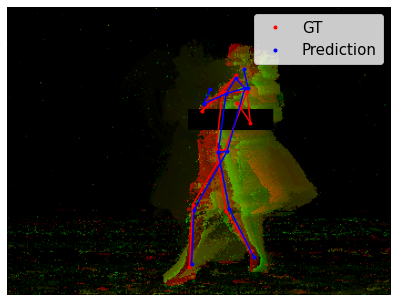

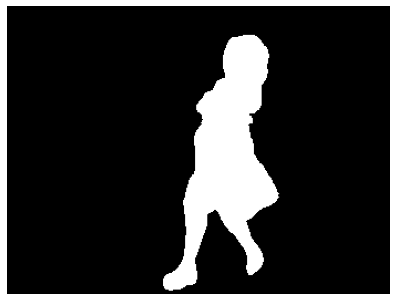

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


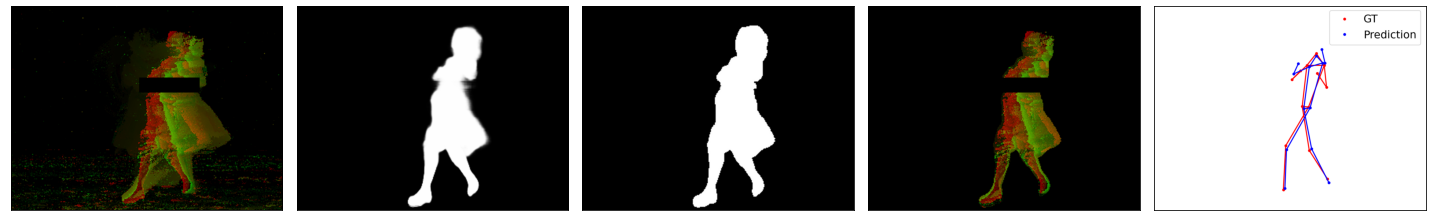

In [80]:
rec = build_rec(b_x=b_x, b_y=b_y, normed_pred_joints=normed_pred_joints, masks=masks, model=model)
figs_dict = vis_center(rec, 10, vis_config={
                'overlay_comp':True,
                'overlay_pred':False,
                'mask_pred':False,
                'mask_binary':True,
                'mask_gt':False,
                'tore_bands':False,
                'pred_ori_3d':False,
                'gt_ori_3d':False,
                'pred_normed_3d':False,
                'gt_normed_3d':False,
                'full_row':True
            }, ret_fig=True)

In [ ]:
write_all_figs(figs_dict, root='results/occlusion')

In [45]:
idx=420
case_root = r'C:\Users\miracleyoo\OneDrive - kcchub\Phase1\dataset\synthetic'
case_name = 'Albedo_front_nature_sea'
data_path = op.join(case_root, case_name, 'meta.json')
reader = ToreSeqReader([data_path], labels_processed=False, 
                        percentile=90, redundant_labels=True, time_count_baseline=False,
                        occlusion=True,
                        occlusion_rate=1)
print('TORE Reader Initialized!')
batch = reader.load_seq_by_index(0, idx)
normed_pred_joints, masks, b_x, b_y = inference(batch, model)

mask_rec = dotdict({
    'pred_mask': masks.cpu().detach().squeeze().numpy(),
    'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
})

TORE Reader Initialized!


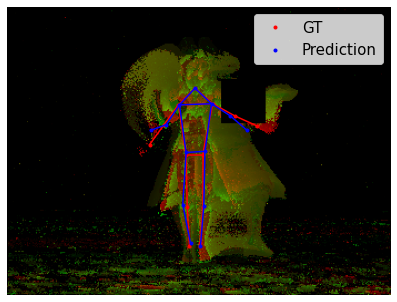

In [46]:
inbatch_idx = 6
combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
intrinsic_matrix = b_y['camera'][0]
extrinsic_matrix = b_y['M'][0]
pred_skcam = model.denormalize_predictions(normalized_predictions=normed_pred_joints, b_y=b_y)
pred_skori = np.array([reproject_xyz_onto_world_coord(pred_skcam[i], b_y['M'][i]).numpy() for i in range(16)])
overlay_fig = plot_2d_overlay(b_y['xyz'][inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, plot_lines=True, ret_fig=True, pred_pose=pred_skori[inbatch_idx])
# overlay_fig = plot_2d_overlay(pred_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, plot_lines=True, ret_fig=True)

## Load Model and Data Interface

In [6]:
model = load_model(time_str=model_date_dict['MiDHP']['w_cl'], best=True, device='cuda', root=midhp_root)

L:\DVS\models\hpe\MiDHP\05-25-16-19-04\checkpoints\best-epoch=97-val_loss=0.079.ckpt
Model init entered!
[√] Using ConvLSTM in SadPose.
Loading mask net from ckpt!
Model hparams saved!
Output channel number: 16


e:\GitHub\dvs-hpe-light\notebook\..\scripts\model\unet_interface.py:166: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  class_args = inspect.getargspec(Model.__init__).args[1:]


[√] UNet Freezed.
Adding original mpjpe values to results.
Model Initialized.
Using trained model:  L:\DVS\models\hpe\MiDHP\05-25-16-19-04\checkpoints\best-epoch=97-val_loss=0.079.ckpt


In [8]:
data = DataInterface(num_workers=1, dataset='ntore_dataset', batch_size=1, n_joints=13,
                     frame_size=(260,346), estimate_depth=False, torso_length=1.7, 
                     percentile=90, cache_size=1, remove_back_view=False, seq_len=16, gpus=1,
                     data_dir='/gypsum/scratch1/zhongyangzha/DVS_HPE/ntore_dataset/synthetic',
                     use_convlstm=True, cl_skip=True,
                     base_number=16, test_characters=['Diluc','Xiangling'], accumulated=True,
                     cycle_views=True,ori_tore=True, seed=1234, labels_processed=True, redundant_labels=True,
                     front_only=False, remove_db=False, remove_sb=False, partial_dataset=1)
# Initiate train/val/test set and loaders
data.setup()

In [ ]:
# Load data from dataset
idx = 50#680
batch = data.valset[idx]

## Manually Load Data by Name

### Simply Test Mask

In [31]:
case_root = r'C:\Users\miracleyoo\OneDrive - kcchub\exp_dataset\bkg_on\TORE'
idx=300
data_path = op.join(case_root, 'meta.json')
reader = ToreSeqReader([data_path], labels_processed=False, percentile=90, redundant_labels=True)
print('TORE Reader Initialized!')
batch = reader.load_seq_by_index(0, idx)
normed_pred_joints, masks, b_x, b_y = inference(batch, model)

mask_rec = dotdict({
    'pred_mask': masks.cpu().detach().squeeze().numpy(),
    'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
})

TORE Reader Initialized!


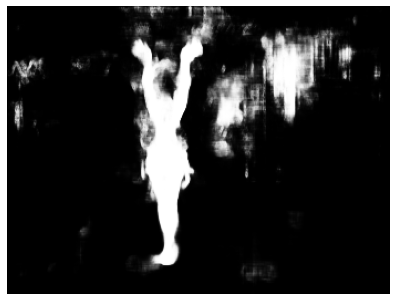

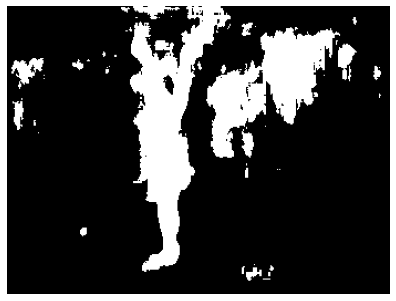

In [32]:
inbatch_idx = 15
fig=plt.figure(figsize=(7.05,5.2875))
plt.imshow(mask_rec['pred_mask'][inbatch_idx], cmap='gray')
plt.axis('off')
plt.show()
fig=plt.figure(figsize=(7.05,5.2875))
plt.imshow(mask_rec['bn_mask'][inbatch_idx], cmap='gray')
plt.axis('off')
plt.show()

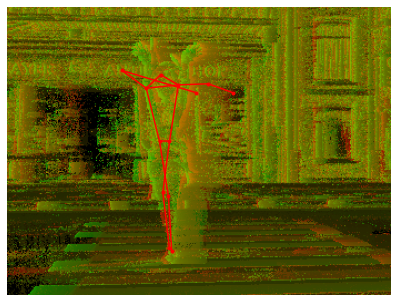

In [36]:
combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
intrinsic_matrix = b_y['camera'][0]
extrinsic_matrix = b_y['M'][0]
pred_skcam = model.denormalize_predictions(normalized_predictions=normed_pred_joints, b_y=b_y)
pred_skori = np.array([reproject_xyz_onto_world_coord(pred_skcam[i], b_y['M'][i]).numpy() for i in range(16)])
overlay_fig = plot_2d_overlay(pred_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, plot_lines=True, ret_fig=True)

### Original Data Systematic Test

In [114]:
data_root = r'C:\Users\miracleyoo\OneDrive - kcchub\dataset\synthetic'
mask_root = r'C:\Users\miracleyoo\OneDrive - kcchub\dataset\masks_acc'

idx=518 #530
case_name = 'Albedo_back_nature_stream_sll'#'Seele_front_city_street' #'Tartaglia_left_outdoor_cars_lowlight' #'Albedo_back_nature_stream_sll' #'Seele_front_city_street' #'Xiangling_right_city_street3_sll'
data_path = op.join(data_root, case_name, 'meta.json')
human_name, camera_view = case_name.split('_')[:2]
mask_path = op.join(mask_root, human_name, f'{camera_view}_alpha')
reader = ToreSeqReader([data_path], labels_processed=False, percentile=90, redundant_labels=True)
print('TORE Reader Initialized!')
batch = reader.load_seq_by_index(0, idx)
print('TORE batch Loaded!')
mask_reader = MaskSeqReader(root=mask_path)
print('Mask Reader Initialized!')

TORE Reader Initialized!
TORE batch Loaded!
Mask Reader Initialized!


## Start inference

In [10]:
# Inference are done here
b_x, b_y = batch
del b_y['name']
for k in b_y.keys():
    b_y[k] = torch.tensor(b_y[k])
b_x = torch.tensor(b_x).float()
normed_pred_joints, masks = model.predict_step(b_x.unsqueeze(0).to(device), idx)
normed_pred_joints = normed_pred_joints.cpu().detach()
del batch

intrinsic_matrix = b_y['camera'][0]
extrinsic_matrix = b_y['M'][0]
print('Label Keys: ', b_y.keys())
print('Extrinsic:\n', b_y['M'][0].numpy().round(2))
print('Intrinsic:\n', b_y['camera'][0].numpy().round(2))
# print('GT Normed:\n', b_y['normalized_skeleton'].numpy()[0].round(3))

Label Keys:  dict_keys(['xyz', 'skeleton', 'normalized_skeleton', 'z_ref', '2d_joints', 'M', 'camera', 'mask'])
Extrinsic:
 [[ 1.  0.  0.  0.]
 [ 0.  0. -1.  1.]
 [ 0.  1.  0.  5.]]
Intrinsic:
 [[485.17   0.   173.     0.  ]
 [  0.   485.17 130.     0.  ]
 [  0.     0.     1.     0.  ]]


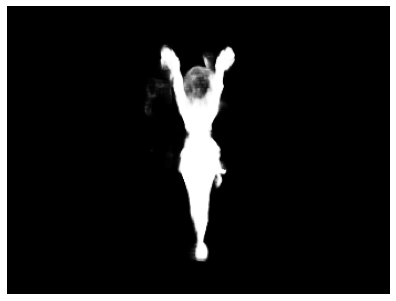

In [13]:
fig=plt.figure(figsize=(7.05,5.2875))
plt.imshow(masks[0].cpu().numpy()[0], cmap='gray')
plt.axis('off')
plt.show()

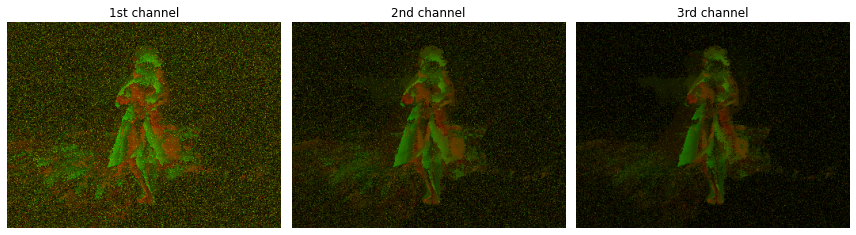

In [116]:
# Input NTORE Sanity Check
inbatch_idx = 0
check_ntore(b_x[inbatch_idx])

## Generate the necessary items for comparison

In [118]:
pred_skcam = model.denormalize_predictions(normalized_predictions=normed_pred_joints, b_y=b_y)
pred_skori = np.array([reproject_xyz_onto_world_coord(pred_skcam[i], b_y['M'][i]).numpy() for i in range(16)])

sks = dotdict({
    'gt_skcam': b_y['skeleton'].numpy(),
    'gt_sknormed': b_y['normalized_skeleton'].numpy(),
    'gt_skori': b_y['xyz'].numpy(),
    'pred_skcam': pred_skcam.numpy(),
    'pred_sknormed': normed_pred_joints.numpy(),
    'pred_skori': pred_skori,
    'pred_mask': masks.cpu().detach().squeeze().numpy(),
    'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
    'gt_mask': np.stack([mask_reader.read_acc_frame(idx+i) for i in range(16)]),
})

sks.delta_skori = np.abs(sks.gt_skori - sks.pred_skori) 
sks.delta_sknormed = np.abs(sks.gt_sknormed - sks.pred_sknormed)
sks.delta_skcam = np.abs(sks.gt_skcam - sks.pred_skcam)

In [121]:
inbatch_idx = 0

# print('Predicted original skeleton:\n', sks.pred_skori[inbatch_idx].round(3))
# print('GT original skeleton:\n', sks.gt_skori[inbatch_idx].round(3))
# print('Predicted Normalized skeleton:\n', sks.pred_sknormed[inbatch_idx].round(3))
# print('GT Normalized skeleton:\n', sks.gt_sknormed[inbatch_idx].round(3))
# print('Delta original skeleton:\n', sks.delta_skori[inbatch_idx].round(2))
print('Delta normalized skeleton:\n', sks.delta_sknormed[inbatch_idx].round(2))


Delta normalized skeleton:
 [[0.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.01 0.01 0.01]
 [0.01 0.   0.  ]
 [0.02 0.   0.  ]
 [0.   0.02 0.  ]
 [0.01 0.01 0.  ]
 [0.   0.03 0.  ]
 [0.   0.01 0.  ]
 [0.01 0.02 0.  ]
 [0.01 0.   0.  ]]


In [122]:
# MPJPE
torch.mean(mpjpe(torch.tensor(sks.gt_skori[inbatch_idx]), torch.tensor(sks.pred_skori[inbatch_idx])))*1000

tensor(41.4205)

In [123]:
# mpjpe(torch.tensor(sks.gt_skori[inbatch_idx]), torch.tensor(sks.pred_skori[inbatch_idx])).cpu().detach().tolist()
torch.mean(mpjpe(torch.tensor(sks.gt_skori), torch.tensor(sks.pred_skori)).cpu().detach())


tensor(0.0318)

## Predicted Results Check and Comparison

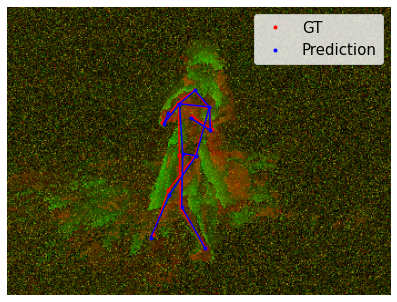

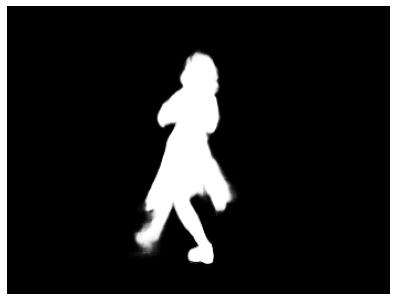

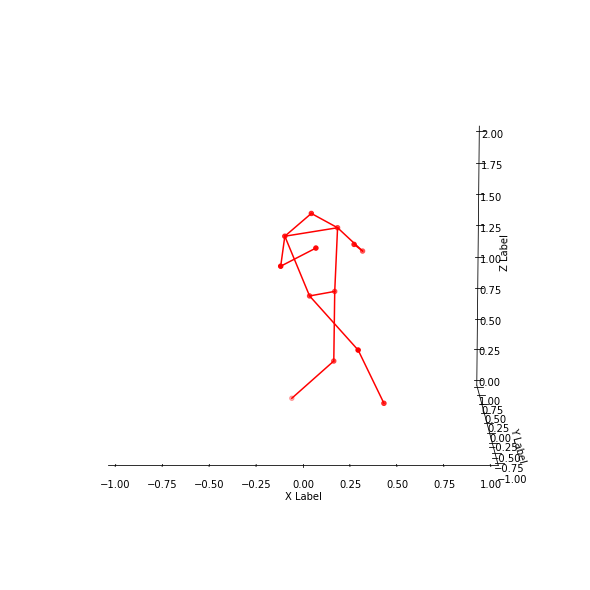

In [124]:
combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
# # Only label pose
# plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size)
# # Only label pose
# plot_2d_overlay(sks.pred_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size)
# Both pose
overlay_fig = plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, pred_pose=sks.pred_skori[inbatch_idx], plot_lines=True, ret_fig=True)

fig=plt.figure(figsize=(7.05,5.2875))
plt.imshow(sks.pred_mask[inbatch_idx], cmap='gray')
plt.axis('off')
plt.show()

plot_skeleton_3d(sks.gt_skori[inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

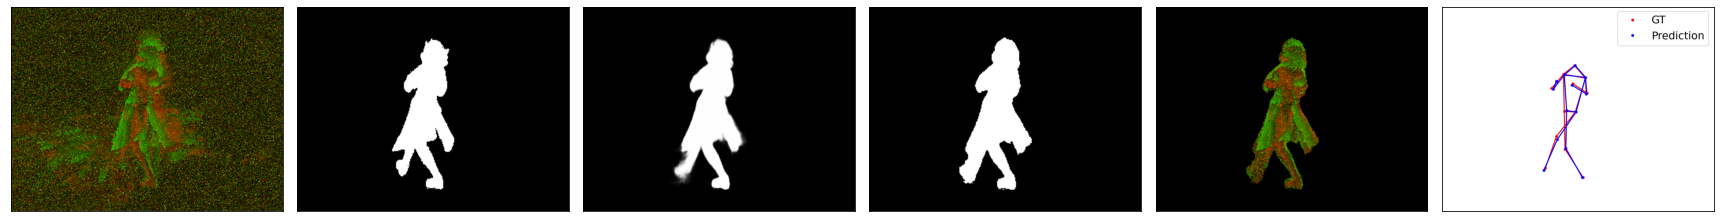

In [126]:
fig_row = ntore_to_redgreen(b_x[inbatch_idx])
pred_mask_vis = sks.pred_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)
bn_mask_vis = sks.bn_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)
gt_mask_vis = sks.gt_mask[inbatch_idx][np.newaxis,...].repeat(3,axis=0).astype(float)

masked_tore_vis = combined_ntore[0]*sks.bn_mask[inbatch_idx].astype(float)
ones_frame = np.ones_like(masked_tore_vis)*255
overlay_fig = plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, ones_frame.transpose(1,2,0), frame_size=frame_size, pred_pose=sks.pred_skori[inbatch_idx], plot_lines=True, ret_fig=True, show=False)

# overlay_vis=cv2.resize(get_img_from_fig(overlay_fig), dsize=(346,260), interpolation=cv2.INTER_AREA).transpose(2,0,1).astype(float)/255
overlay_vis=get_img_from_fig(overlay_fig).transpose(2,0,1).astype(float)/255

# Full Version
# fig_row = np.vstack((fig_row, gt_mask_vis[np.newaxis,...], pred_mask_vis[np.newaxis,...], bn_mask_vis[np.newaxis,...], masked_tore_vis[np.newaxis,...], overlay_vis[np.newaxis,...]))

# Selected Version
# fig_row = np.vstack((fig_row[:1], gt_mask_vis[np.newaxis,...], pred_mask_vis[np.newaxis,...], bn_mask_vis[np.newaxis,...], overlay_vis[np.newaxis,...]))
fig_row = [fig_row[0], gt_mask_vis, pred_mask_vis, bn_mask_vis, masked_tore_vis, overlay_vis]
fig_row = [f.transpose(1,2,0) for f in fig_row]
_, newh, neww = overlay_vis.shape
for j, f in enumerate(fig_row[:-1]):
#     print(f.shape)
    fig_row[j] = cv2.resize(f, dsize=(neww, newh), interpolation=cv2.INTER_CUBIC)
    

# print(fig_row.shape)

# batch_show(fig_row.transpose(0,2,3,1))
big_fig_row = batch_show(fig_row, ret_fig=True, sub_size=(4,3.5))
big_vis_row = get_img_from_fig(big_fig_row, dpi=300, pad_inches=0.01)
cv2.imwrite(f'./results/big_row/{time_string()}.png', cv2.cvtColor(big_vis_row, cv2.COLOR_BGR2RGB))

# NiDHP(YeLan-Real Dataset) Prediction

In [235]:
device = 'cuda'
frame_size = (260, 346)
mpjpe = MPJPE()
model = load_model(time_str=model_date_dict['NiDHP']['pretrain'], best=True, device='cuda', root=nidhp_root)
print('Using trained model: ', model_path)
print('Mask application strategy: ', model.model.mask_strategy)

L:\DVS\models\hpe\NiDHP\06-02-00-34-40\checkpoints\best-epoch=87-val_loss=0.049.ckpt
Model init entered!
[√] Using ConvLSTM in SadPose.
Loading mask net from ckpt!
Model hparams saved!


e:\GitHub\dvs-hpe-light\notebook\..\scripts\model\unet_interface.py:166: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  class_args = inspect.getargspec(Model.__init__).args[1:]


Output channel number: 16
[√] UNet Freezed.
Adding original mpjpe values to results.
Model Initialized.
Using trained model:  L:\DVS\models\hpe\NiDHP\06-02-00-34-40\checkpoints\best-epoch=87-val_loss=0.049.ckpt
Using trained model:  L:\DVS\models\hpe\MiDHP\05-25-18-04-07\checkpoints\best-epoch=92-val_loss=0.073.ckpt
Mask application strategy:  mask


In [236]:
def nidhp_predict(reader, idx, model=model, verbose=True): #, quality=4):
    batch = reader.load_seq_by_index(0, idx)
    b_x, b_y = batch
    del b_y['name']
    for k in b_y.keys():
        b_y[k] = torch.tensor(b_y[k])
    b_x = torch.tensor(b_x).float()
    normed_pred_joints, masks = model.predict_step(b_x.unsqueeze(0).to(device), idx)
    normed_pred_joints = normed_pred_joints.cpu().detach()
    del batch

    intrinsic_matrix = b_y['camera'][0]
    extrinsic_matrix = b_y['M'][0]
    if verbose:
        print('Label Keys: ', b_y.keys())
        print('Extrinsic:\n', b_y['M'][0].numpy().round(2))
        print('Intrinsic:\n', b_y['camera'][0].numpy().round(2))
    
    pred_skcam = model.denormalize_predictions(normalized_predictions=normed_pred_joints, b_y=b_y)
    pred_skori = np.array([reproject_xyz_onto_world_coord(pred_skcam[i], b_y['M'][i]).numpy() for i in range(16)])

    sks = dotdict({
        'gt_skcam': b_y['skeleton'].numpy(),
        'gt_sknormed': b_y['normalized_skeleton'].numpy(),
        'gt_skori': b_y['xyz'].numpy(),
        'pred_skcam': pred_skcam.numpy(),
        'pred_sknormed': normed_pred_joints.numpy(),
        'pred_skori': pred_skori,
        'pred_mask': masks.cpu().detach().squeeze().numpy(),
        'bn_mask': torch.where(masks>0.1,1,0).cpu().detach().squeeze().numpy(),
    })

    sks.delta_skori = np.abs(sks.gt_skori - sks.pred_skori) 
    sks.delta_sknormed = np.abs(sks.gt_sknormed - sks.pred_sknormed)
    sks.delta_skcam = np.abs(sks.gt_skcam - sks.pred_skcam)
    return b_x, b_y, sks, intrinsic_matrix, extrinsic_matrix

def nidhp_vis(b_x, sks, intrinsic_matrix, extrinsic_matrix, inbatch_idx=0, frame_size=frame_size, verbose=True):
    if verbose:
        print("Mean MPJPE:", torch.mean(mpjpe(torch.tensor(sks.gt_skori), torch.tensor(sks.pred_skori)).cpu().detach()).item())
    check_ntore(b_x[inbatch_idx])

    combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
    overlay_fig = plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, pred_pose=sks.pred_skori[inbatch_idx], plot_lines=True, ret_fig=True)

    fig=plt.figure(figsize=(7.05,5.2875))
    plt.imshow(sks.pred_mask[inbatch_idx], cmap='gray')
    plt.axis('off')
    plt.show()
#     get_img_from_fig(overlay_fig)

def nidhp_frame(b_x, sks, intrinsic_matrix, extrinsic_matrix, inbatch_idx=0, frame_size=frame_size, quality=4):
    combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
    overlay_fig = plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, pred_pose=sks.pred_skori[inbatch_idx], plot_lines=True, ret_fig=True, show=False)
    return get_img_from_fig(overlay_fig, dpi=quality*36)

def generate_pos_rgdvs_video(reader,
                             model=model,
                             out_path='results/output.mp4',
                             quality=4,
                             fps=50,
                             frame_num=None):
    b_x, b_y, sks, intrinsic_matrix, extrinsic_matrix = nidhp_predict(reader, idx=0, model=model, verbose=False)

    frame = nidhp_frame(b_x, sks, intrinsic_matrix, extrinsic_matrix, inbatch_idx=0, quality=quality)
    h, w = frame.shape[:-1]
    frame_num = reader.metas[0]['total_tore_count'] if frame_num is None else min(
        frame_num, reader.metas[0]['total_tore_count'])

    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
    for idx in trange(frame_num//16):
        b_x, b_y, sks, intrinsic_matrix, extrinsic_matrix = nidhp_predict(reader, idx=idx*16, model=model, verbose=False)
        for inbatch_idx in range(16):
            frame = nidhp_frame(b_x, sks, intrinsic_matrix, extrinsic_matrix, inbatch_idx=inbatch_idx, quality=quality)[:, :, ::-1]
            out.write(frame)
    out.release()

In [253]:
data_path = r'L:\DVS\ddhp22\DVS_FORMAL\S10\Processed_VF\S10-200FPS\S10_SBHL_T0007\meta.json'

identifier = Path(data_path).parts[-2]
reader = ToreSeqReader([data_path], labels_processed=False, percentile=90, redundant_labels=True)
print("Total TORE number in this reader: ", reader.metas[0]['total_tore_count'])

Total TORE number in this reader:  4271


In [254]:
idx = 768
inbatch_idx=15
b_x, b_y, sks, intrinsic_matrix, extrinsic_matrix = nidhp_predict(reader, idx, model=model)

Label Keys:  dict_keys(['xyz', 'skeleton', 'normalized_skeleton', 'z_ref', '2d_joints', 'M', 'camera', 'mask'])
Extrinsic:
 [[ 1.    0.04  0.02 -0.09]
 [ 0.03 -0.17 -0.99  0.81]
 [-0.03  0.98 -0.17  3.75]]
Intrinsic:
 [[256.28   0.   172.09   0.  ]
 [  0.   255.61 119.09   0.  ]
 [  0.     0.     1.     0.  ]]


In [1]:
# generate_pos_rgdvs_video(reader, model, out_path=f'results/{identifier}_overlay.mp4')

Mean MPJPE: 0.0785447284579277


c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


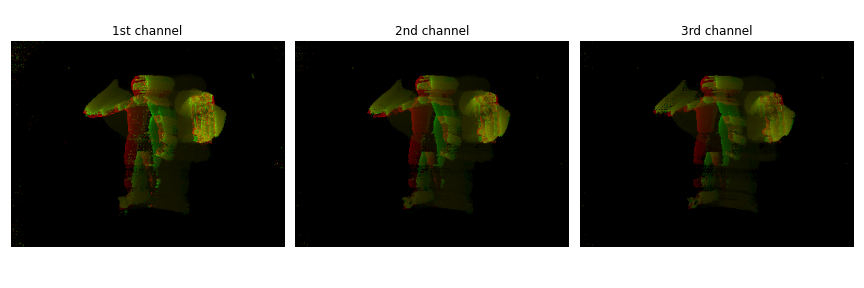

c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is depreca

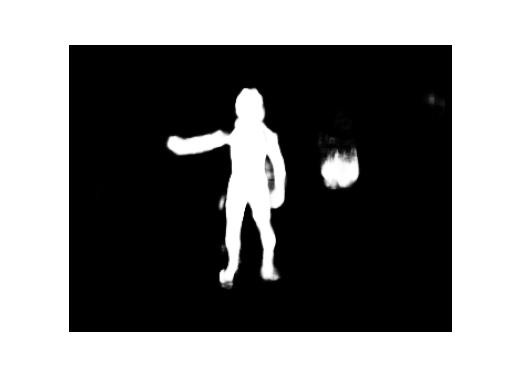

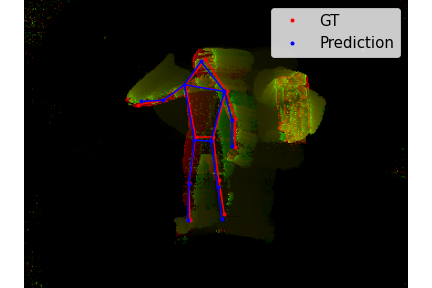

In [193]:
print("Mean MPJPE:", torch.mean(mpjpe(torch.tensor(sks.gt_skori), torch.tensor(sks.pred_skori)).cpu().detach()).item())

inbatch_idx = 15
check_ntore(b_x[inbatch_idx])

combined_ntore = ntore_to_redgreen(b_x[inbatch_idx])
overlay_fig = plot_2d_overlay(sks.gt_skori[inbatch_idx], intrinsic_matrix, extrinsic_matrix, combined_ntore[0].transpose(1,2,0), frame_size=frame_size, pred_pose=sks.pred_skori[inbatch_idx], plot_lines=True, ret_fig=True)

fig=plt.figure(figsize=(7.05,5.2875))
plt.imshow(sks.pred_mask[inbatch_idx], cmap='gray')
plt.axis('off')
plt.show()

# plot_skeleton_3d(sks.gt_skori[inbatch_idx], limits = [[-1, 1], [-1, 1], [0, 2]])

c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
c:\Users\miracleyoo\Anaconda3\envs\dvs_pose\lib\site-packages\ipywidgets\widgets\widget.py:412: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


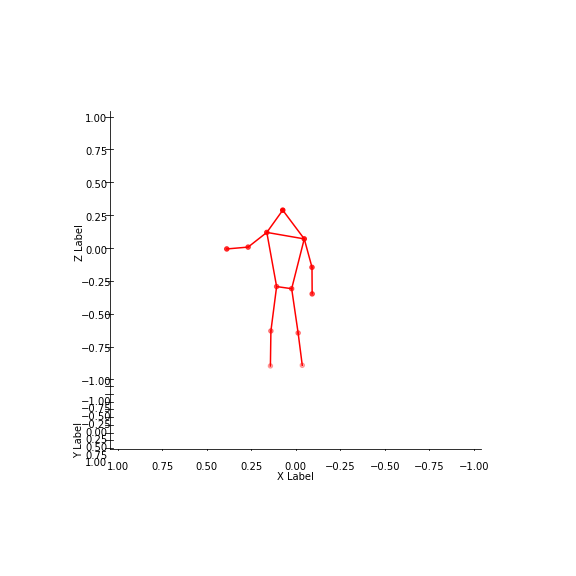

In [197]:
plot_skeleton_3d(sks['pred_sknormed'][inbatch_idx][:, np.r_[0,2,1]], limits=((-1,1),(-1,1),(-1,1)), angle=90, no_perspective=True)